In [101]:
import os
import re
from glob import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize
from scipy.optimize import curve_fit
import numpy as np
from astropy.io import fits

from winterdrp_offline.image_operations import (
    median_combine_images,
    merge_channels_into_data,
    normalize_and_median_combine_images,
    split_data_into_channels,
    package_image_list_into_mef,
    package_image_data_into_mef,
)
from winterdrp_offline.labflats import (
    filter_exposures_with_both_light_and_dark,
    get_dark_frames_for_exposure,
    get_light_frames_for_exposure,
    get_unique_exposures_in_ascending_order,
    load_fits_directory,
    load_light_and_dark_frames,
    parse_filename,
)
from winterdrp_offline.utils import get_table_from_ldac, plot_image, write_image

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))


## Build Stacks
The lab data is a series of dark and light exposures for exposure times with these exposure times: [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]. For each exposure time there are 10 images. We want to do a few things:
- build multi-extension fits "stacks" that can be used to calculate the photon-transfer function on a pixel-by-pixel basis. We need to build both light and dark stacks
- build the same multi-extension stacks but chunked up on a channel-by-channel basis to see what differences in behavior we see between output channels
- build stacks of light frames that have the median dark frame subtracted off. These are an intermediate step in the PTC so saving this out will make life easier.

In [102]:
base_dir = Path(
    os.path.join(
        os.getenv("HOME"), "data", "calibration_hackathon", "hackathon_datasets"
    )
)


flat_dir = base_dir.joinpath(f"flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse")

In [103]:
# Build the stacks
# load the light and dark frames
flat_light_dir = flat_dir.joinpath("flat/raw")
flat_dark_dir = flat_dir.joinpath("dark/raw")

df_all = load_light_and_dark_frames(flat_light_dir, flat_dark_dir)
#print("Combined (light & dark) frames:")
#print(df_all)
df_filtered = filter_exposures_with_both_light_and_dark(df_all)
print("\nFiltered to exposures with both light and dark frames:")
#print(df_filtered)

exposures_sorted = get_unique_exposures_in_ascending_order(df_filtered)
print("\nUnique exposures in ascending order (that have both light and dark):")
print(exposures_sorted)

addr = "PC"

# now go through each exposure time and get the light and dark frames, and make the median combined light and dark frames
for exp_time in exposures_sorted:
    # Example of retrieving specific frames:
    #print(f"\nLight frames at exposure_time={exp_time}:")
    light_frames = get_light_frames_for_exposure(df_filtered, exp_time)
    dark_frames = get_dark_frames_for_exposure(df_filtered, exp_time)

    median_light_frame = median_combine_images(light_frames["filepath"])
    median_dark_frame = median_combine_images(dark_frames["filepath"])

    exp_time_ms = f"{exp_time*1000:.0f}ms"

    # combine the light frames into a single multi-extension FITS file
    output_dir = flat_dir.joinpath("stacks/full_frame/lights")
    output_dir.mkdir(parents=True, exist_ok=True)
    output_filepath = output_dir.joinpath(f"{addr}_IWR_Raw_-15C_lights_{exp_time_ms}.fits")
    package_image_list_into_mef(light_frames["filepath"], output_filepath)

    # combine the dark frames into a single multi-extension FITS file
    output_dir = flat_dir.joinpath("stacks/full_frame/darks")
    output_dir.mkdir(parents=True, exist_ok=True)
    output_filepath = output_dir.joinpath(f"{addr}_IWR_Raw_-15C_darks_{exp_time_ms}.fits")
    package_image_list_into_mef(dark_frames["filepath"], output_filepath)


    # go through each light frame and subtract the median dark frame
    output_dir = flat_dir.joinpath("stacks/dark_subtracted")
    output_dir.mkdir(parents=True, exist_ok=True)
    median_dark_subtracted_light_frames = []
    for filepath in light_frames["filepath"]:
        img = fits.getdata(filepath)
        img -= median_dark_frame
        median_dark_subtracted_light_frames.append(img)
    # write the stack of median dark-subtracted light frames to a multi-extension FITS file
    output_filepath = output_dir.joinpath(f"{addr}_IWR_Raw_-15C_lights_{exp_time_ms}_med_darksub.fits")
    package_image_data_into_mef(median_dark_subtracted_light_frames, output_filepath)





    # channelize the frames
    output_dir = flat_dir.joinpath("stacks/channelized/lights")
    output_dir.mkdir(parents=True, exist_ok=True)

    # for each file in the list of light frames at the current exposure time, import the image and then split it into channels
    # initialize a list for each channel. we will append each channel to the list and then write the list to a multi-extension FITS file
    channelized_light_frames = [[] for _ in range(8)]
    for filepath in light_frames["filepath"]:
        img = fits.getdata(filepath)
        img_channels = split_data_into_channels(img)
        for i in range(8):
            channelized_light_frames[i].append(img_channels[i])

    # write the channelized light frames to a multi-extension FITS file
    for chan in range(8):
        output_filepath = output_dir.joinpath(f"{addr}{chan}_IWR_Raw_-15C_lights_{exp_time_ms}.fits")
        package_image_data_into_mef(channelized_light_frames[chan], output_filepath)

    # channelize the dark frames
    output_dir = flat_dir.joinpath("stacks/channelized/darks")
    output_dir.mkdir(parents=True, exist_ok=True)

    # for each file in the list of dark frames at the current exposure time, import the image and then split it into channels
    # initialize a list for each channel. we will append each channel to the list and then write the list to a multi-extension FITS file
    channelized_dark_frames = [[] for _ in range(8)]
    for filepath in dark_frames["filepath"]:
        img = fits.getdata(filepath)
        img_channels = split_data_into_channels(img)
        for i in range(8):
            channelized_dark_frames[i].append(img_channels[i])
    
    # write the channelized dark frames to a multi-extension FITS file
    for chan in range(8):
        output_filepath = output_dir.joinpath(f"{addr}{chan}_IWR_Raw_-15C_darks_{exp_time_ms}.fits")
        package_image_data_into_mef(channelized_dark_frames[chan], output_filepath)

    


    # plot the median light and dark frames
    #ax = plot_image(median_light_frame)
    #ax.set_title(f"Median light frame at {exp_time} seconds")
    #ax = plot_image(median_dark_frame)
    #ax.set_title(f"Median dark frame at {exp_time} seconds")

    


Filtered to exposures with both light and dark frames:

Unique exposures in ascending order (that have both light and dark):
[0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]


## Ramp Examination
Now that we have the median dark-subtracted data frames, let's see what the ramps look like! 


   exp_time                                           filepath  \
7     0.005  /Users/nlourie/data/calibration_hackathon/hack...   
1     0.010  /Users/nlourie/data/calibration_hackathon/hack...   
5     0.020  /Users/nlourie/data/calibration_hackathon/hack...   
6     0.040  /Users/nlourie/data/calibration_hackathon/hack...   
8     0.060  /Users/nlourie/data/calibration_hackathon/hack...   
9     0.080  /Users/nlourie/data/calibration_hackathon/hack...   
0     0.100  /Users/nlourie/data/calibration_hackathon/hack...   
2     0.120  /Users/nlourie/data/calibration_hackathon/hack...   
3     0.140  /Users/nlourie/data/calibration_hackathon/hack...   
4     0.160  /Users/nlourie/data/calibration_hackathon/hack...   

                                                data  
7  [[[118.5, 125.0, 109.5, 107.5, 94.5, 98.0, 107...  
1  [[[96.5, 106.0, 104.5, 94.5, 88.0, 77.5, 114.5...  
5  [[[129.0, 123.5, 111.0, 97.0, 111.5, 107.0, 93...  
6  [[[95.5, 89.5, 107.5, 96.0, 80.0, 76.5, 96.0, ... 

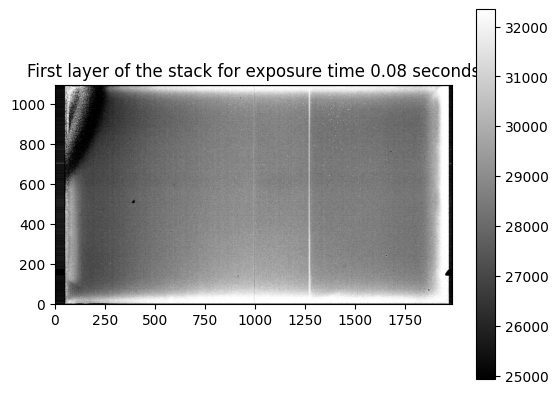

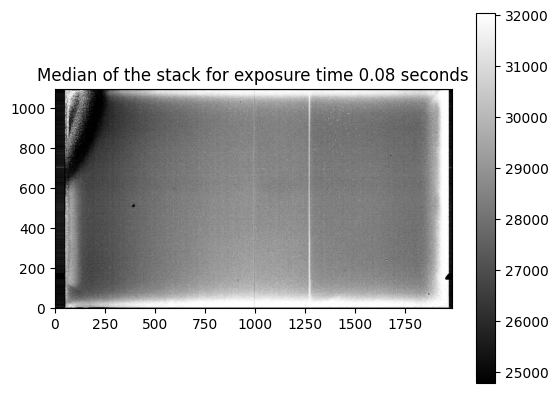

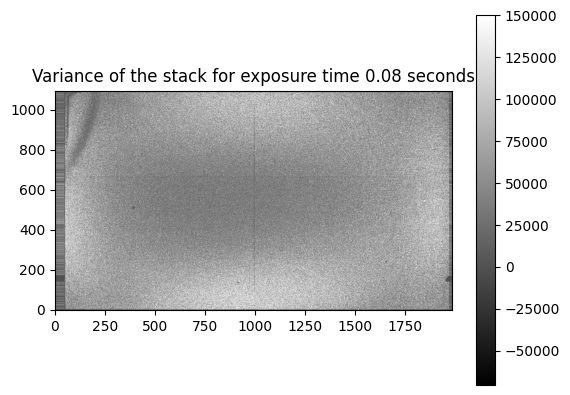

In [104]:
# Load in the median dark subtracted light frames
data_dir = flat_dir.joinpath("stacks/dark_subtracted")
data_filepaths = sorted(data_dir.glob("*.fits"))

# The data all have names like this:PC_IWR_Raw_-15C_lights_160ms_med_darksub.fits
# We need to extract the exposure time from the filename. Build a pandas data frame with the exposure time and the file path
rows = []

for filepath in data_filepaths:
    filename = filepath.name  # if `filepath` is a Path object
    match = re.search(r"_(\d+)ms", filename)
    if match:
        exp_time = int(match.group(1)) / 1000
        rows.append({
            "exp_time": exp_time,
            "filepath": str(filepath),  # or just `filepath` if you prefer
            "data": fits.getdata(filepath),
        })
    else:
        # If there's no match, handle it as needed—skip it, assign NaN, log an error, etc.
        pass

df = pd.DataFrame(rows).sort_values("exp_time")
print(df)

# Example: plot the first layer of the stack for exposure time 0.080 seconds
exp_time = 0.080
print()
print(f'in each stack, there are {len(df.iloc[0]["data"])} layers')

plot_image(df[df["exp_time"] == exp_time].iloc[0]["data"][0], title=f"First layer of the stack for exposure time {exp_time} seconds")

# Example: plot the median of the stack for specified exposure time
exp_time = 0.080
stack_data = df[df["exp_time"] == exp_time].iloc[0]["data"]
# what is the shape of the data?
print(f"shape of the data: {stack_data.shape}")
median_data = np.median(stack_data, axis=0)
print(f"shape of the median data: {median_data.shape}")
plot_image(median_data, title=f"Median of the stack for exposure time {exp_time} seconds")

# calculate the variance of the stack for specified exposure time
variance_data = np.var(stack_data, axis=0)
plot_image(variance_data, title=f"Variance of the stack for exposure time {exp_time} seconds")


# Now we will step through each row in the dataframe and calculate the median and variance of the stack, then add those data to the dataframe
df["median"] = df["data"].apply(lambda stack: np.median(stack, axis=0))
df["variance"] = df["data"].apply(lambda stack: np.var(stack, axis=0))

print("Data frame after adding median and variance data:")
# print the data frame showing all columns
print(pd.DataFrame(rows))

# Define an ROI. Then for each pixel in the ROI plot the median value vs exposure time and the variance vs exposure time
roi_center = [147, 1025]
roi_width = 1
roi_height = 1
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]

#for x, y in [(roi_coords[0] + i, roi_coords[1] + j) for i in range(roi_height) for j in range(roi_width)]:




    

In [ ]:
# The slow way! loop through all the pixels in the full image one by one. Took 5 min.
print(f"image shape = {df.iloc[0]['median'].shape}")
slope_image = np.zeros(df.iloc[0]["median"].shape)
intercept_image = np.zeros(df.iloc[0]["median"].shape)
gain_image = np.zeros(df.iloc[0]["median"].shape)

for x in range(df.iloc[0]["median"].shape[1]):
    for y in range(df.iloc[0]["median"].shape[0]):
        median_values = []
        variance_values = []
        exp_times = []
        for i, row in df.iterrows():
            if (row["exp_time"] > 0.025) and (row["exp_time"] < 0.105):
                median_values.append(row["median"][y, x])
                variance_values.append(row["variance"][y, x])
                exp_times.append(row["exp_time"])

        # fit a line to the median vs variance data
        p = np.polyfit(median_values, variance_values, 1)

        # calculate the gain from the slope of the line
        gain = p[0]**-1
        gain_image[y, x] = gain
        slope_image[y, x] = p[0]
        intercept_image[y, x] = p[1]





image shape = (1096, 1984)


Stacked median shape = (7, 1096, 1984)
Stacked variance shape = (7, 1096, 1984)


/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_16097/870666393.py:18: RuntimeWarning: Mean of empty slice
  x_mean = np.nanmean(log_median, axis=0)
/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_16097/870666393.py:21: RuntimeWarning: invalid value encountered in subtract
  diff_x = log_median - x_mean
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_16097/870666393.py:40: RuntimeWarning: overflow encountered in exp
  A_image = np.exp(intercept_image)


slope_image.shape: (1096, 1984)
intercept_image.shape: (1096, 1984)


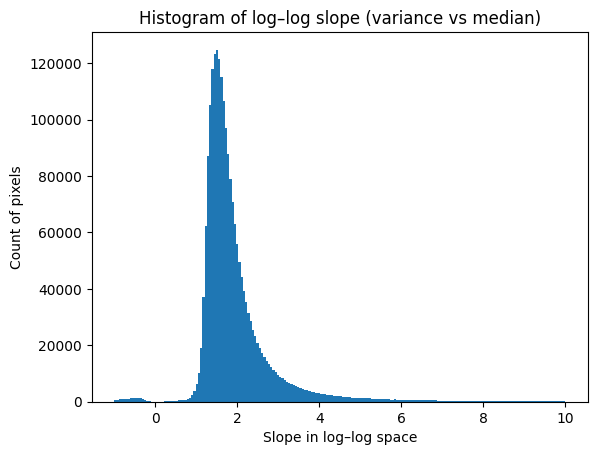

In [ ]:
# Filter exposure times
#mask = (df["exp_time"] > 0.025) & (df["exp_time"] < 0.105)
mask = (df["exp_time"] < 0.105)

df_filtered = df[mask].copy()
arr_median   = np.stack(df_filtered["median"].values, axis=0)   # shape (N, H, W)
arr_variance = np.stack(df_filtered["variance"].values, axis=0) # shape (N, H, W)

N, H, W = arr_median.shape
print(f"Stacked median shape = {arr_median.shape}")
print(f"Stacked variance shape = {arr_variance.shape}")

with np.errstate(divide='ignore', invalid='ignore'):
    log_median   = np.log(arr_median)   # shape (N, H, W)
    log_variance = np.log(arr_variance) # shape (N, H, W)

# Means in log space
x_mean = np.nanmean(log_median, axis=0)
y_mean = np.nanmean(log_variance, axis=0)

diff_x = log_median - x_mean
diff_y = log_variance - y_mean

num = np.nansum(diff_x * diff_y, axis=0)
den = np.nansum(diff_x * diff_x, axis=0)

with np.errstate(divide='ignore', invalid='ignore'):
    slope_image = num / den
    slope_image[den == 0] = np.nan

intercept_image = y_mean - slope_image * x_mean

gain_image = 1 / slope_image

print("slope_image.shape:", slope_image.shape)
print("intercept_image.shape:", intercept_image.shape)

# For example, interpret 'variance = A * (median)^slope' where A = exp(intercept).
with np.errstate(divide='ignore', invalid='ignore'):
    A_image = np.exp(intercept_image)

# Example: Plot hist of slopes
plt.hist(gain_image.ravel(), bins=200, range=(-1, 10))
plt.title("Histogram of log–log slope (variance vs median)")
plt.xlabel("Slope in log–log space")
plt.ylabel("Count of pixels")
plt.show()

median gain = 1.689
1/median gain = 0.592
[np.int64(23030), np.float32(1.47), 0.1]


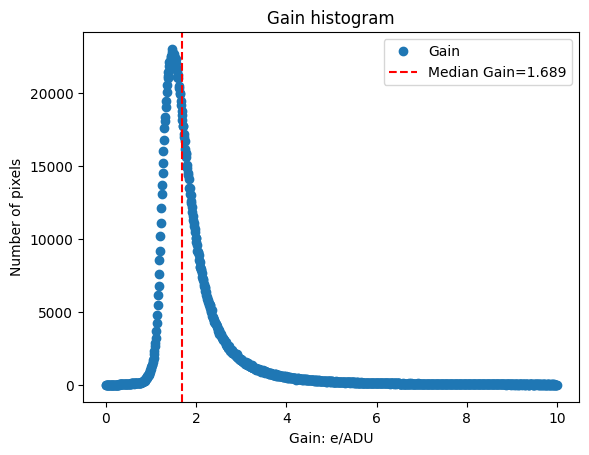

In [ ]:
# plot a histogram of all the calculated gains
fig, ax = plt.subplots()
hist = np.histogram(np.ravel(gain_image), bins=1000, range=(0, 10))
ax.plot(hist[1][:-1], hist[0], 'o', label="Gain")
ax.set_title("Gain histogram")

# calculate the median gain:
median_gain = np.nanmedian(np.ravel(gain_image))
print(f"median gain = {median_gain:0.3f}")
print(f"1/median gain = {1/median_gain:0.3f}")
# plot a vertical dashed line at the median gain
ax.axvline(median_gain, color='r', linestyle='--', label = f"Median Gain={median_gain:0.3f}")
ax.set_xlabel("Gain: e/ADU")
ax.set_ylabel("Number of pixels")

# fit a gaussian to the histogram
xhist = hist[1][:-1]
yhist= hist[0]
mean_guess = xhist[np.argmax(yhist)]#np.nanmedian(gain_image)
std_guess = 0.1#np.nanstd(gain_image)


# fit a gaussian to the histogram
hist_clipcond = (yhist>2500)
xhist_clip = xhist[hist_clipcond]
yhist_clip = yhist[hist_clipcond]
#ax.plot(xhist_clip,yhist_clip, label=f"Data to Fit")

param_guess = [np.nanmax(yhist_clip), mean_guess, std_guess]
print(param_guess)

popt, pcov = curve_fit(
    gaussian,
    xhist_clip,
    yhist_clip,
    p0=param_guess,
    maxfev=5000,
)
# get the fit parameters
gauss_amplitude, gauss_mean, gauss_std = popt
gauss_std_err = np.sqrt(np.diag(pcov))

# plot the fit
#ax.plot(xhist, gaussian(xhist, *popt), label="Gaussian fit")


# turn on the legend
ax.legend()
plt.show()



Using ALL 10 exposures from df.
arr_median_all.shape  = (10, 1096, 1984)
arr_variance_all.shape = (10, 1096, 1984)


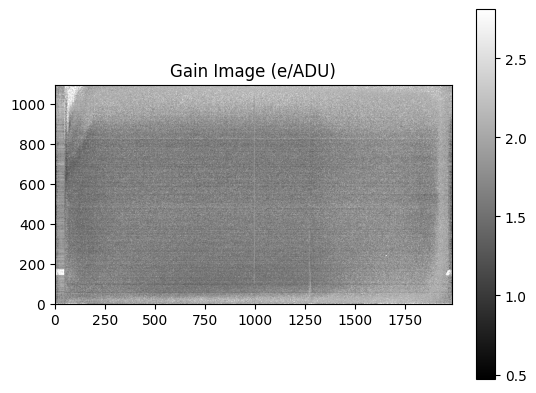

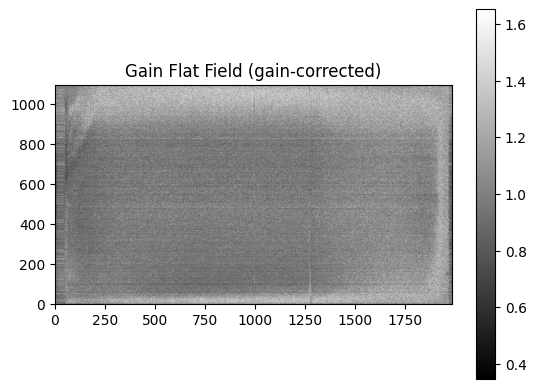

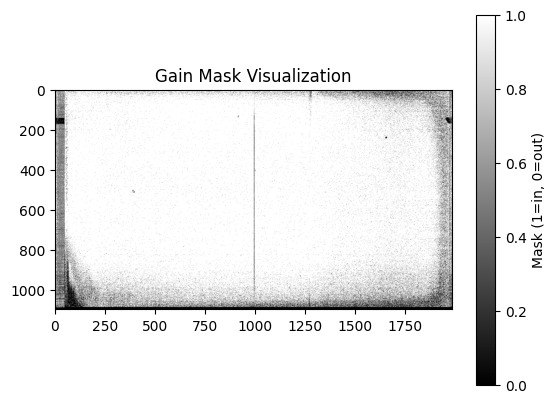

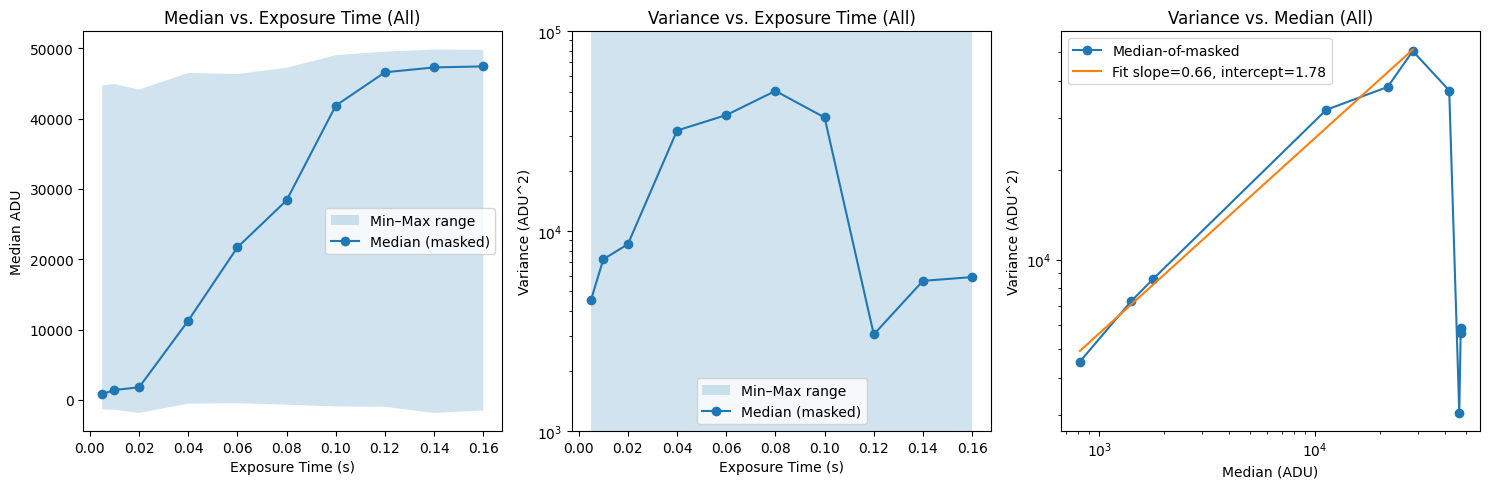

In [ ]:
########################################
# 1) Keep the gain_mask computed earlier
########################################
Nsigma = 5
gain_mask = np.abs(gain_image - median_gain) < Nsigma * gauss_std

# also: plot the masked gain_image
fig, ax = plt.subplots()
masked_gain_image = gain_image.copy()
masked_gain_image[~gain_mask] = np.nan
plot_image(masked_gain_image, ax=ax, title="Gain Image (e/ADU)")

# make a flat field from the masked gain_image
gain_flat = gain_image / median_gain
gain_flat[~gain_mask] = 1.0
plot_image(gain_flat, title="Gain Flat Field (gain-corrected)")

# save the gain flat
output_dir = flat_dir.joinpath("calibration_flats")
output_filepath = output_dir.joinpath(f"{addr}_IWR_Raw_-15C_gain_flat.fits")
write_image(gain_flat, output_filepath)

########################################
# 2) Build arrays from the *entire* df
########################################
arr_median_all = np.stack(df["median"].values, axis=0)       # shape (Nall, H, W)
arr_variance_all = np.stack(df["variance"].values, axis=0)   # shape (Nall, H, W)
exp_times_all = df["exp_time"].values                        # shape (Nall,)

Nall, H, W = arr_median_all.shape
print(f"Using ALL {Nall} exposures from df.")
print(f"arr_median_all.shape  = {arr_median_all.shape}")
print(f"arr_variance_all.shape = {arr_variance_all.shape}")

########################################
# 3) Visualize the gain_mask if desired
########################################
fig, ax = plt.subplots()
mask_display = gain_mask.astype(float)  # 1.0 for True, 0.0 for False
im = ax.imshow(mask_display, cmap='gray')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Mask (1=in, 0=out)")
plt.title("Gain Mask Visualization")
plt.show()

########################################
# 4) Apply gain_mask to these full arrays
########################################
# masked_medians_all: shape (Nall, #mask_pixels)
masked_medians_all   = arr_median_all[:, gain_mask]
masked_variances_all = arr_variance_all[:, gain_mask]

# Compute min, max, median across the masked pixels at each exposure
median_min_all = np.min(masked_medians_all, axis=1)
median_max_all = np.max(masked_medians_all, axis=1)
median_med_all = np.median(masked_medians_all, axis=1)

var_min_all = np.min(masked_variances_all, axis=1)
var_max_all = np.max(masked_variances_all, axis=1)
var_med_all = np.median(masked_variances_all, axis=1)

########################################
# 5) Plot results vs. *all* exposure times
########################################
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# (a) Median vs. exposure time
axs[0].fill_between(exp_times_all, median_min_all, median_max_all, 
                    alpha=0.2, label="Min–Max range")
axs[0].plot(exp_times_all, median_med_all, 'o-', label="Median (masked)")
axs[0].set_title("Median vs. Exposure Time (All)")
axs[0].set_xlabel("Exposure Time (s)")
axs[0].set_ylabel("Median ADU")
axs[0].legend()

# (b) Variance vs. exposure time (semi-log)
axs[1].fill_between(exp_times_all, var_min_all, var_max_all, 
                    alpha=0.2, label="Min–Max range")
axs[1].semilogy(exp_times_all, var_med_all, 'o-', label="Median (masked)")
axs[1].set_title("Variance vs. Exposure Time (All)")
axs[1].set_xlabel("Exposure Time (s)")
axs[1].set_ylabel("Variance (ADU^2)")
axs[1].set_ylim(1e3, 1e5)
axs[1].legend()

# (c) Variance vs. median on log–log
axs[2].loglog(median_med_all, var_med_all, 'o-', label="Median-of-masked")
axs[2].set_title("Variance vs. Median (All)")
axs[2].set_xlabel("Median (ADU)")
axs[2].set_ylabel("Variance (ADU^2)")

# Fit a power law (log–log slope) to *all* points
valid = (median_med_all < 30000) & (var_med_all > 0)
p = np.polyfit(np.log10(median_med_all[valid]), np.log10(var_med_all[valid]), 1)
slope, intercept = p[0], p[1]
axs[2].plot(
    median_med_all[valid],
    10**np.polyval(p, np.log10(median_med_all[valid])),
    '-', label=f"Fit slope={slope:.2f}, intercept={intercept:.2f}"
)

axs[2].legend()
plt.tight_layout()
plt.show()

## Assess with a flat:
Let's see if we can use this "gain flat" to flatten a flat

<Axes: title={'center': 'Sample Flat Corrected'}>

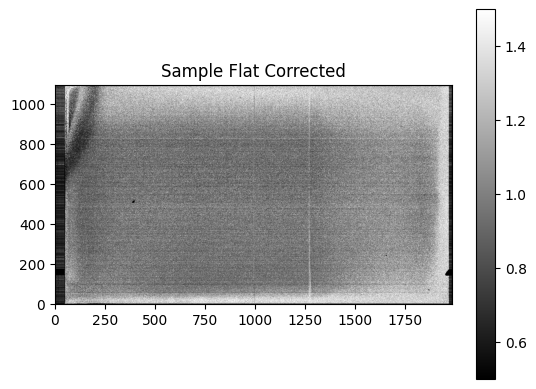

In [ ]:
flat_dir = base_dir.joinpath(f"flats/lab_flats/pc_2_60nA_post_mods_ptc-coarse")
sample_flat = flat_dir.joinpath('calibration_flats/lab_flat_0.06s.fits')
sample_flat_data = fits.getdata(sample_flat)

# Apply the gain flat field to the sample flat
sample_flat_corrected = sample_flat_data * gain_flat
# plot the corrected flat
norm = ImageNormalize(vmin = 0.5, vmax = 1.5)
plot_image(sample_flat_corrected, title="Sample Flat Corrected", norm = norm)

